In [ ]:
# Import the necessary libraries
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import os.path

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

from sklearn.model_selection import train_test_split


In [ ]:
# Download the necessary files for the dataset, Skip this part if you already have the dataset Downloaded

# !gdown --id 1qUz-I-pu2W079toEsmitEpmdnDc6digg
# !gdown --id 1vm7carQEWQGRmSdwkvTPy7IJEhuGqtIn
!gdown --id 1-jkPhru6HdLI9FFMHQO2LP9-wbLYQ-N5



/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-jkPhru6HdLI9FFMHQO2LP9-wbLYQ-N5
To: /content/Collated-3.rar
100% 140M/140M [00:03<00:00, 44.1MB/s]


In [ ]:
!ls

Collated-3.rar	sample_data


In [ ]:
# Extracts the downloaded dataset from gdrive

!unrar x "Collated-3.rar" "Collated/"

Streaming output truncated to the last 5000 lines.
Extracting  Collated/Collated/O/O_7.jpg                                   54%  OK 
Extracting  Collated/Collated/O/O_70.jpg                                  54%  OK 
Extracting  Collated/Collated/O/O_71.jpg                                  54%  OK 
Extracting  Collated/Collated/O/O_72.jpg                                  54%  OK 
Extracting  Collated/Collated/O/O_73.jpg                                  54%  OK 
Extracting  Collated/Collated/O/O_74 (2).jpg                              54%  OK 
Extracting  Collated/Collated/O/O_74.jpg                                  54%  OK 
Extracting  Collated/Collated/O/O_75.jpg                                  54%  OK 
Extracting  Collated/Collated/O/O_76.jpg                                  54%  OK 
Extracting  Collated/Collated/O/O_77.jpg                                  54%  OK 
Extracting  Collated/Collated

In [ ]:
# Define helper functions

# Convert folder to dataframe of images' paths & labels
def get_paths_labels(path, allowed_extension="jpg"):
        global Path
        images_dir = Path(path)

        filepaths = pd.Series((images_dir.glob(fr'**/*.jpg'))).astype(str)
        filepaths.name = "path"

        labels = filepaths.str.split("/")[:].str[-2]
        labels.name = "label"

        # Concatenate filepaths and labels
        df = pd.concat([filepaths, labels], axis=1)

        # Shuffle the DataFrame and reset index
        df = df.sample(frac=1).reset_index(drop = True)
        return df

In [ ]:
# Read image
def get_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [ ]:
# Visualize samples
def visualize_samples(datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)

    classes = np.array(list(datagen.class_indices))
    print("classes", classes)
    labels = classes[np.array(datagen.labels)[random_indexes]]
    print("labels", labels)
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    images = filepaths.apply(get_image).reset_index(drop=True)

    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(labels[sample_index])
            ax[i,j].set_axis_off()
    plt.show()

In [ ]:
# Process image (input) for the model
def process(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = tf.keras.applications.mobilenet.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img


# Make classifications & visualize results
def visualize_classifications(model, datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)

    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]

    images = filepaths.apply(get_image).reset_index(drop=True)
    processed_images = np.vstack(images.apply(process).to_numpy()[:])

    y_pred = classes[np.argmax(model.predict(processed_images, verbose=0), axis=1)]
    y_true = labels

    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)

    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(f"Y true({y_true[sample_index]}) | Y pred ({y_pred[sample_index]})")
            ax[i,j].set_axis_off()
    plt.show()

In [ ]:
# Read datasets

# Create dataframe of {paths, labels}
# train_df = get_paths_labels('images/train/')
# train_df = get_paths_labels('Dataset/Dataset/')
train_df = get_paths_labels('Collated/')


# Import another dataset (to train model on various data)
# temp_df = get_paths_labels('images/test/')





# Combine both datasets
# dataset = pd.concat((train_df, temp_df))
# dataset = pd.concat(train_df)

dataset = train_df

In [ ]:
# View Combined Datasets

dataset.head()

path label
0                       Collated/Collated/V/4504.jpg     V
1                       Collated/Collated/V/V_59.jpg     V
2  Collated/Collated/G/896_jpg.rf.139ba91efa1c652...     G
3   Collated/Collated/U/Image_1667034849.0342155.jpg     U
4   Collated/Collated/I/Image_1667019049.4519973.jpg     I

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11700 entries, 0 to 11699
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    11700 non-null  object
 1   label   11700 non-null  object
dtypes: object(2)
memory usage: 182.9+ KB


In [ ]:
# Classes counts
print("Classes counts")
counts = dataset.iloc[:,1].value_counts().sort_index()
print(counts.head(counts.shape[0]))
print(f"\n\nDataset size = {counts.sum()} samples")

Classes counts
A    450
B    450
C    450
D    450
E    450
F    450
G    450
H    450
I    450
J    450
K    450
L    450
M    450
N    450
O    450
P    450
Q    450
R    450
S    450
T    450
U    450
V    450
W    450
X    450
Y    450
Z    450
Name: label, dtype: int64


Dataset size = 11700 samples


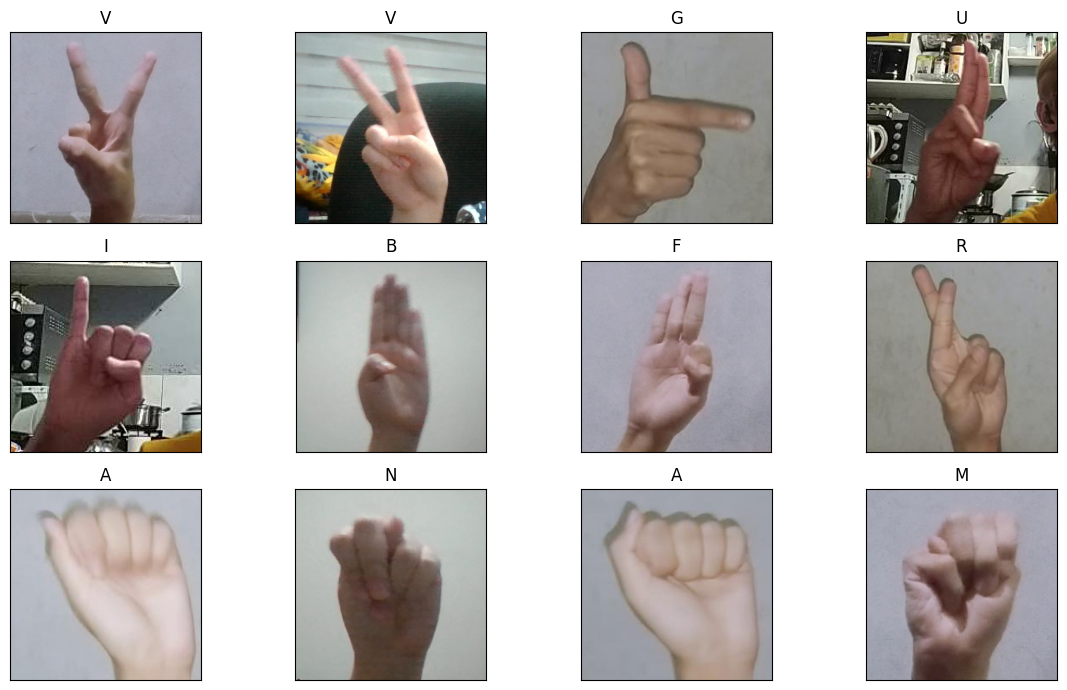

In [ ]:
# Visualize Dataset

fig, axes = plt.subplots(3, 4, figsize=(12, 7), subplot_kw={'xticks': [], 'yticks': []})
for idx, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(dataset.path[idx]))
    ax.set_title(dataset.label[idx])
plt.tight_layout()
plt.show()

In [ ]:
# Split Dataset to Training and Testing data
df_train, df_test = train_test_split(dataset, test_size=0.1, random_state=42)

In [ ]:
print('Training size: {} images\nTest size: {} images'.format(len(df_train), len(df_test)))


Training size: 10530 images
Test size: 1170 images


In [ ]:
# Generators

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2 # 20% of the training data will be used for validation
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
BATCH_SIZE = 64

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col='path',
    y_col='label',
    color_mode='rgb',
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

Found 8424 validated image filenames belonging to 26 classes.


In [ ]:
val_images = train_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col='path',
    y_col='label',
    color_mode='rgb',
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 2106 validated image filenames belonging to 26 classes.


In [ ]:
test_images = test_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col='path',
    y_col='label',
    color_mode='rgb',
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 1170 validated image filenames belonging to 26 classes.


In [ ]:
# Neural network architecture

pretrainedModel = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
     include_top=False,
     weights='imagenet',
     pooling='avg'
)
pretrainedModel.trainable = False

inputs = pretrainedModel.input

x = tf.keras.layers.Dense(256, activation='relu')(pretrainedModel.output)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

# x = tf.keras.layers.Dropout(0.2)(pretrainedModel.output)



outputs = tf.keras.layers.Dense(26, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer_adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Compile model
model.compile(
    optimizer=optimizer_adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50, # since we are running on CPU, we keep the number of epoch low
    callbacks=[
        tf.keras.callbacks.EarlyStopping( # we apply earlystopping to prevent overfitting
            monitor='val_loss',
            patience=3, # we choose patience=3 to stop the model fit if val_loss won't decrease for 3 epoch
            restore_best_weights=True # choose the best weights when early-stopping
        )
    ]
)

Epoch 1/50
132/132 [==============================] - 46s 269ms/step - loss: 2.7534 - accuracy: 0.2444 - val_loss: 1.8661 - val_accuracy: 0.6529
Epoch 2/50
132/132 [==============================] - 36s 269ms/step - loss: 1.5303 - accuracy: 0.5977 - val_loss: 0.8136 - val_accuracy: 0.8637
Epoch 3/50
132/132 [==============================] - 33s 252ms/step - loss: 0.8672 - accuracy: 0.7688 - val_loss: 0.4586 - val_accuracy: 0.9179
Epoch 4/50
132/132 [==============================] - 33s 248ms/step - loss: 0.5787 - accuracy: 0.8470 - val_loss: 0.2980 - val_accuracy: 0.9440
Epoch 5/50
132/132 [==============================] - 36s 275ms/step - loss: 0.4270 - accuracy: 0.8890 - val_loss: 0.2266 - val_accuracy: 0.9592
Epoch 6/50
132/132 [==============================] - 37s 282ms/step - loss: 0.3280 - accuracy: 0.9160 - val_loss: 0.1763 - val_accuracy: 0.9644
Epoch 7/50
132/132 [==============================] - 34s 254ms/step - loss: 0.2772 - accuracy: 0.9278 - val_loss: 0.1442 - val_ac

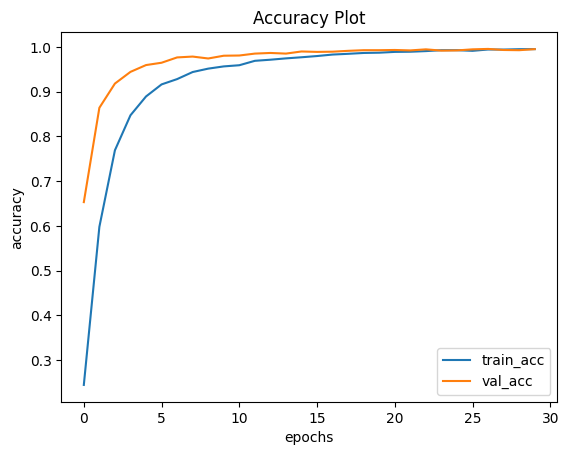

In [ ]:
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title('Accuracy Plot')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

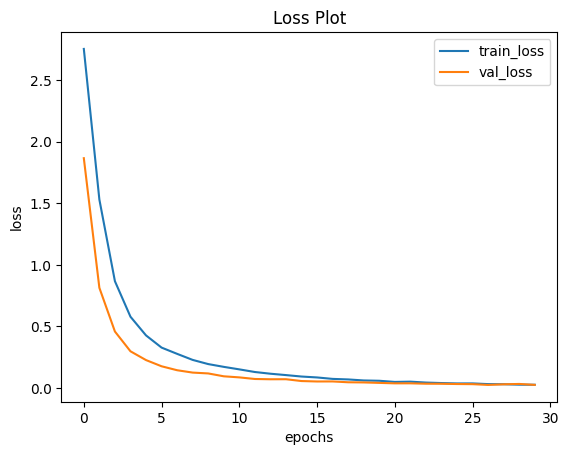

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title('Loss Plot')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
results = model.evaluate(test_images)


19/19 [==============================] - 4s 201ms/step - loss: 0.0360 - accuracy: 0.9880


In [ ]:
print('Training Accuracy: {:.2f}%'.format(history.history["accuracy"][-1:][0]*100))
print('Validation Accuracy: {:.2f}%'.format(history.history["val_accuracy"][-1:][0]*100))
print('Testing Accuracy: {:.2f}%'.format(results[1]*100))

Training Accuracy: 99.48%
Validation Accuracy: 99.48%
Testing Accuracy: 98.80%


In [ ]:
  print('Training Loss: {:.3f}'.format(history.history["loss"][-1:][0]))
print('Validation Loss: {:.3f}'.format(history.history["val_loss"][-1:][0]))
print('Testing Loss: {:.3f}'.format(results[0]))

Training Loss: 0.026
Validation Loss: 0.025
Testing Loss: 0.036


In [ ]:
pred = model.predict(test_images)


19/19 [==============================] - 5s 201ms/step


In [ ]:
pred = np.argmax(pred,axis=1)


In [ ]:
labels_1 = (train_images.class_indices)
labels_1

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25}

In [ ]:
labels = {y:x for x, y in labels_1.items()}
labels

{0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
 10: 'K',
 11: 'L',
 12: 'M',
 13: 'N',
 14: 'O',
 15: 'P',
 16: 'Q',
 17: 'R',
 18: 'S',
 19: 'T',
 20: 'U',
 21: 'V',
 22: 'W',
 23: 'X',
 24: 'Y',
 25: 'Z'}

In [ ]:
pred = [labels[idx] for idx in pred] # create a list of the predicted labels


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns


In [ ]:
y_test = list(df_test.label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           A       0.95      1.00      0.97        39
           B       1.00      1.00      1.00        48
           C       1.00      1.00      1.00        50
           D       1.00      0.98      0.99        56
           E       1.00      1.00      1.00        44
           F       0.98      0.98      0.98        51
           G       1.00      1.00      1.00        47
           H       0.98      1.00      0.99        55
           I       1.00      1.00      1.00        44
           J       1.00      1.00      1.00        33
           K       1.00      0.98      0.99        49
           L       1.00      1.00      1.00        43
           M       0.98      0.98      0.98        43
           N       1.00      0.95      0.97        38
           O       1.00      1.00      1.00        45
           P       1.00      1.00      1.00        53
           Q       1.00      1.00      1.00        40
           R       0.92    

In [ ]:
conf_matrix = confusion_matrix(y_test, pred, normalize = 'true')


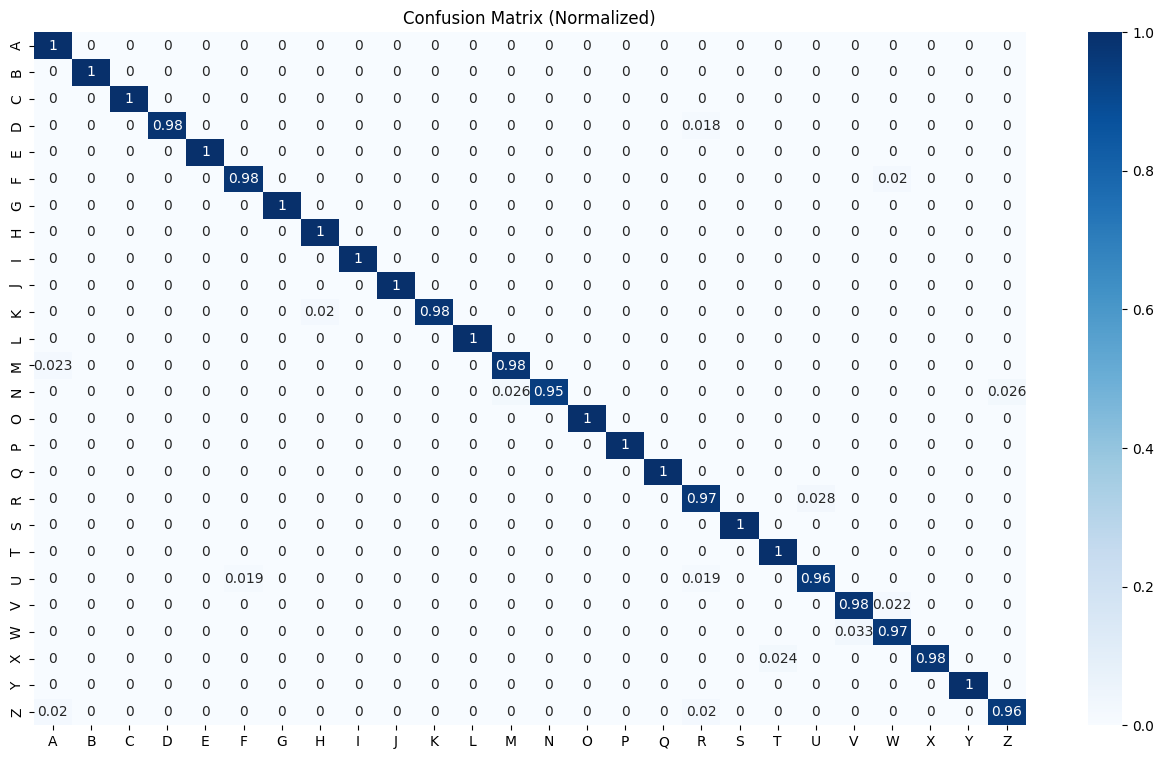

In [ ]:
plt.figure(figsize = (16,9))
sns.heatmap(conf_matrix, cmap='Blues',annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Confusion Matrix (Normalized)')
plt.show()

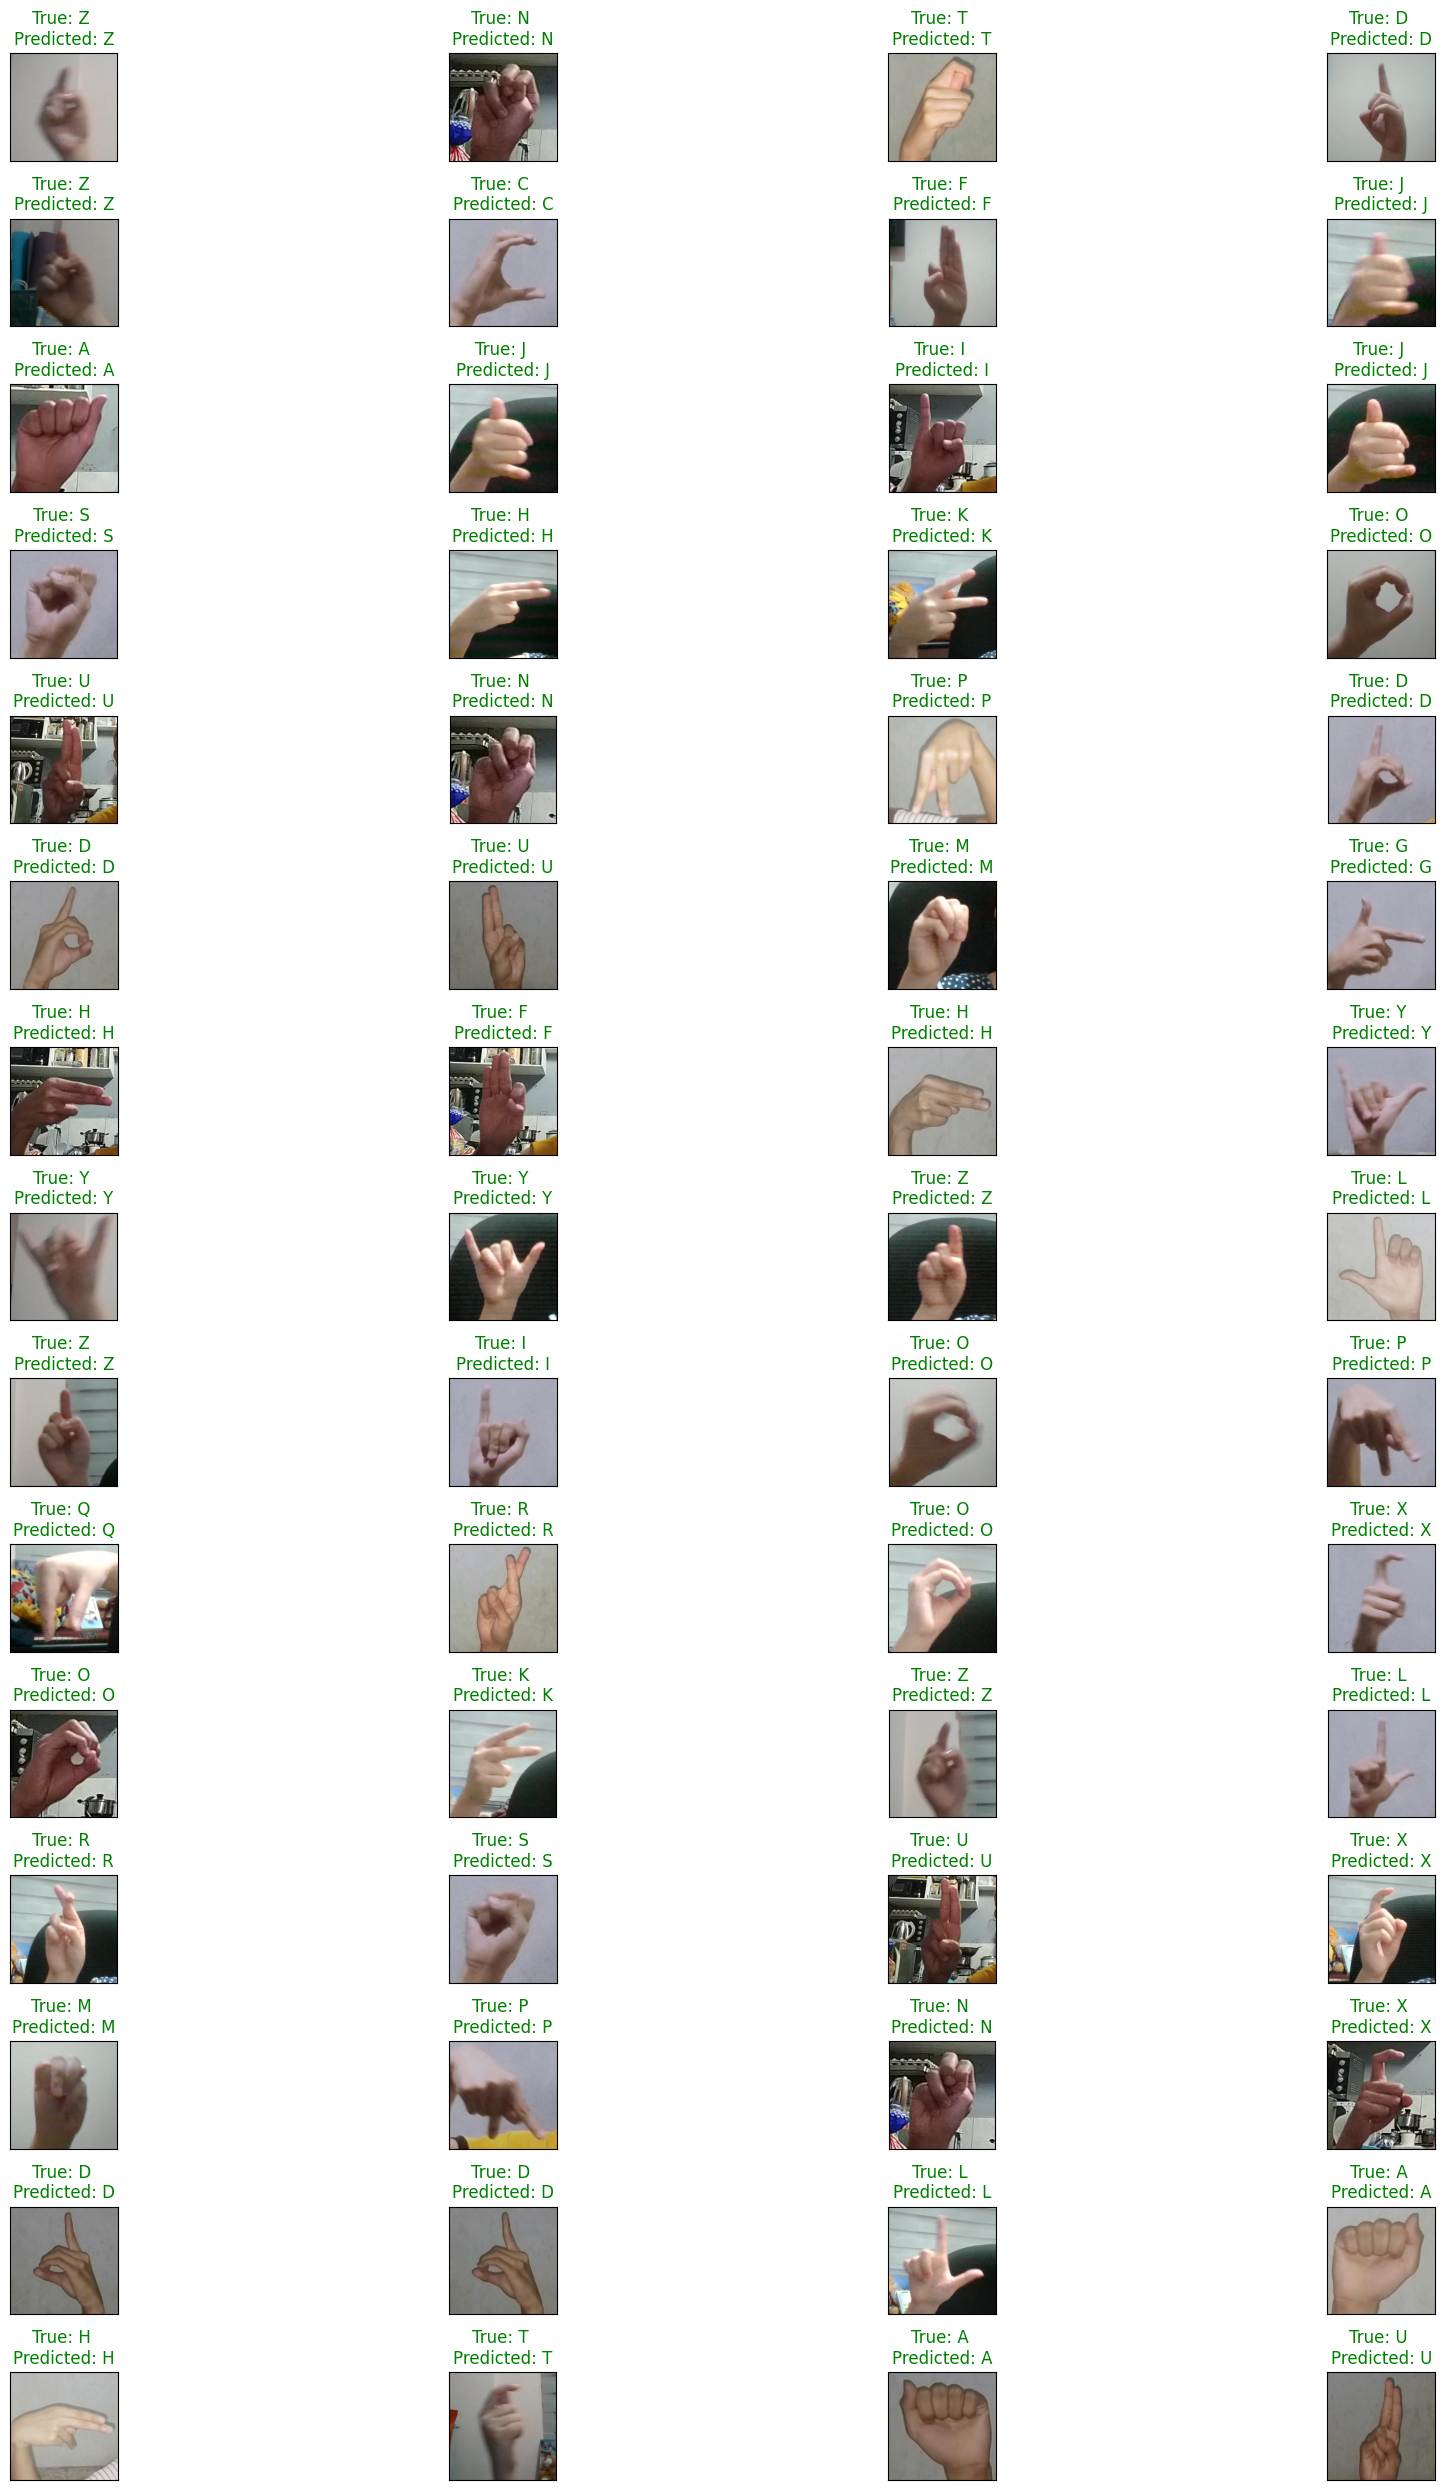

In [ ]:
fig, axes = plt.subplots(nrows=15, ncols=4, figsize=(20, 25), subplot_kw={'xticks': [], 'yticks': []})
for idx, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_test.path.iloc[idx]))
    ax.set_title("True: {} \nPredicted: {}".format(df_test.label.iloc[idx], pred[idx]), color=("green" if pred[idx]==df_test.label.iloc[idx] else "red"))
plt.tight_layout()
plt.show()

In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))

    return cam_path


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

In [ ]:
!mkdir -p saved_model

In [ ]:
history.model.save('saved_model/my_model')


In [ ]:
history.model.save("model_mb2_bs-32_dr-0.2_lr-0.0001_e50_fds-2.h5")

In [ ]:
np.save('history1_model_mb2_bs-32_dr-0.2_lr-0.0001_e50_fds-2.npy',history.history)

In [ ]:
!zip -r saved_model.zip saved_model

  adding: saved_model/ (stored 0%)
  adding: saved_model/my_model/ (stored 0%)
  adding: saved_model/my_model/saved_model.pb (deflated 91%)
  adding: saved_model/my_model/assets/ (stored 0%)
  adding: saved_model/my_model/keras_metadata.pb (deflated 96%)
  adding: saved_model/my_model/variables/ (stored 0%)
  adding: saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: saved_model/my_model/variables/variables.index (deflated 77%)
  adding: saved_model/my_model/fingerprint.pb (stored 0%)


In [ ]:
!ls

Collated						 sample_data
Collated-3.rar						 saved_model
history1_model_mb2_bs-32_dr-0.2_lr-0.0001_e50_fds-2.npy  saved_model.zip
model_mb2_bs-32_dr-0.2_lr-0.0001_e50_fds-2.h5


In [ ]:
from google.colab import files
files.download("saved_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("model_mb2_bs-32_dr-0.2_lr-0.0001_e50_fds-2.h5")
files.download("history1_model_mb2_bs-32_dr-0.2_lr-0.0001_e50_fds-2.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Model Conversion to ONNX
!pip install onnx==1.12
!pip install tf2onnx


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 95.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 2.11.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.1 which is incompatible.
google-cloud-bigquery 3.9.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.1 which is incompatible.
google-cloud-bigquery-storage 2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.2/451.2 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.1 which is incompatible.


In [ ]:
!unzip "saved_model_2.zip"

unzip:  cannot find or open saved_model_2.zip, saved_model_2.zip.zip or saved_model_2.zip.ZIP.


In [ ]:
!python -m tf2onnx.convert --saved-model saved_model/my_model --output saved_model-mb2_bs-32_dr-0.2_lr-0.0001_e50_fds-2.onnx


2023-06-16 06:13:30.199355: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-06-16 06:13:34.091218: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-16 06:13:34,092 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-06-16 06:13:44,936 - INFO - Signatures found in model: [serving_default].
2023-06-16 06:13:44,936 - WARNING - '--signature_def' not specified, using first signature: serving_default
2023-06-16 06:13:44,938 - INFO - Output names: ['dense_2']
2023-06-16 06:13:47,488 - INFO - Using tensorflow=2.12.0, onnx=1.12.0, tf2onnx=1.

In [ ]:
from google.colab import files
files.download("saved_model-mb2_bs-32_dr-0.2_lr-0.0001_e50_fds-2.onnx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

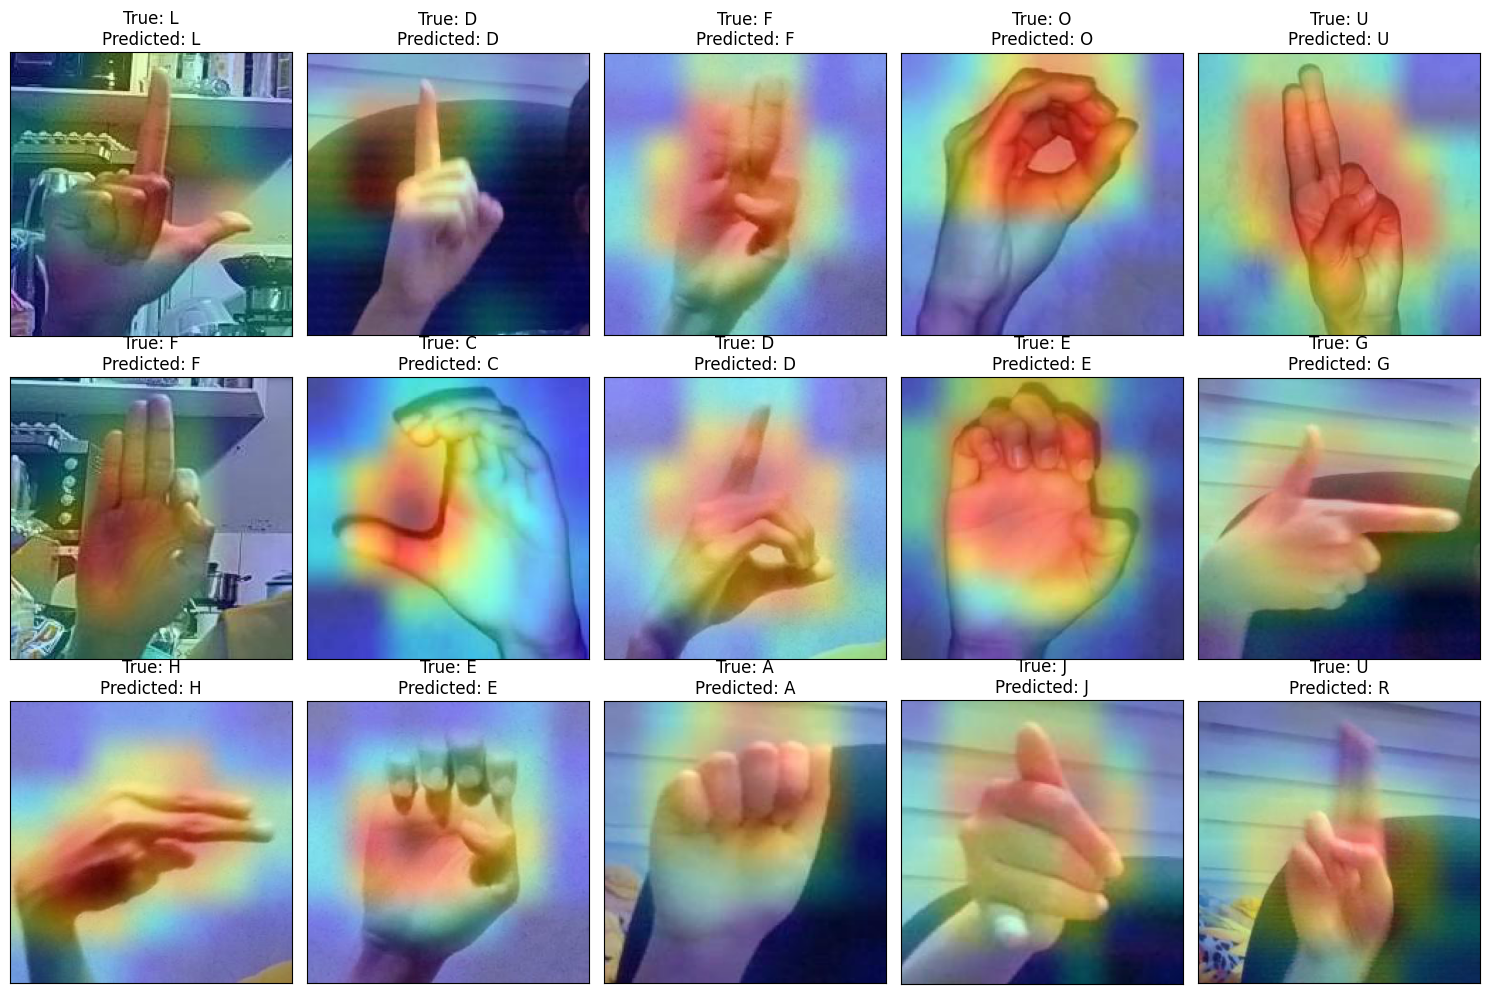

In [ ]:
import matplotlib.cm as cm
import matplotlib as mpl


# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

random_index = np.random.randint(0, len(df_test), 16)

for i, ax in enumerate(axes.flat):
    img_path = df_test.path.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {df_test.label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()